**Libraries**

In [3]:
import os
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import os
import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision
from torchvision import transforms 
import random

In [4]:
# run once to downloading the read_write_mode.py for reading and writing the model
# !wget https://raw.githubusercontent.com/colmap/colmap/dev/scripts/python/read_write_model.py

--2023-06-22 17:22:19--  https://raw.githubusercontent.com/colmap/colmap/dev/scripts/python/read_write_model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21497 (21K) [text/plain]
Saving to: ‘read_write_model.py’

read_write_model.py 100%[===================>]  20.99K  --.-KB/s    in 0s      

2023-06-22 17:22:19 (81.4 MB/s) - ‘read_write_model.py’ saved [21497/21497]



In [5]:
import read_write_model

In [6]:
root='/kaggle/input/image-matching-challenge-2023'
train_label='train_labels.csv'
train_path='/kaggle/input/image-matching-challenge-2023/train/'
test_path='kaggle/input/image-matching-challenge-2023/test/'

In [16]:
train_labels=pd.read_csv('/kaggle/input/image-matching-challenge-2023/train/train_labels.csv')
train_labels.head(2).T

,0,1
dataset,urban,urban
scene,kyiv-puppet-theater,kyiv-puppet-theater
image_path,urban/kyiv-puppet-theater/images/IMG_20220127_...,urban/kyiv-puppet-theater/images/IMG_20220127_...
rotation_matrix,0.961211667939937;0.012901284585988954;0.27550...,0.9983992256415107;0.03067020011152836;0.04752...
translation_vector,-15.272578207792487;-0.6299638684926413;21.960...,-10.86744827847772;5.142649233329267;22.080480...


In [45]:
def get_datasets(root,path):
    file_path = os.path.join(root,path)
    return pd.read_csv(file_path)

In [48]:
get_datasets(train_path,train_label).head(2).T

,0,1
dataset,urban,urban
scene,kyiv-puppet-theater,kyiv-puppet-theater
image_path,urban/kyiv-puppet-theater/images/IMG_20220127_...,urban/kyiv-puppet-theater/images/IMG_20220127_...
rotation_matrix,0.961211667939937;0.012901284585988954;0.27550...,0.9983992256415107;0.03067020011152836;0.04752...
translation_vector,-15.272578207792487;-0.6299638684926413;21.960...,-10.86744827847772;5.142649233329267;22.080480...


In [18]:
train_labels.describe().T

,count,unique,top,freq
dataset,327,3,heritage,247
scene,327,7,dioscuri,174
image_path,327,327,urban/kyiv-puppet-theater/images/IMG_20220127_...,1
rotation_matrix,327,327,0.961211667939937;0.012901284585988954;0.27550...,1
translation_vector,327,327,-15.272578207792487;-0.6299638684926413;21.960...,1


In [17]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327 entries, 0 to 326
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   dataset             327 non-null    object
 1   scene               327 non-null    object
 2   image_path          327 non-null    object
 3   rotation_matrix     327 non-null    object
 4   translation_vector  327 non-null    object
dtypes: object(5)
memory usage: 12.9+ KB


In [19]:
train_labels.isnull().sum()

dataset               0
scene                 0
image_path            0
rotation_matrix       0
translation_vector    0
dtype: int64

**Visualization**

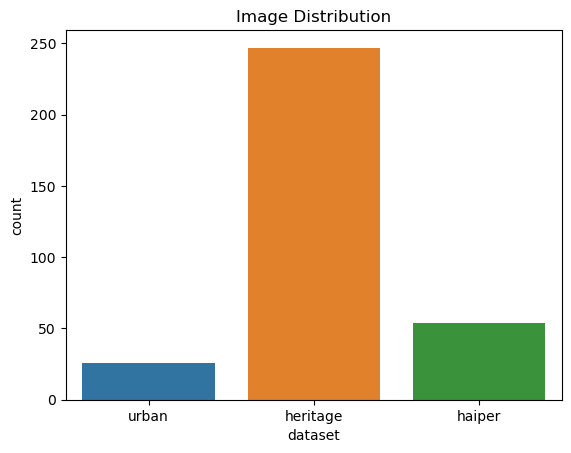

In [24]:
sns.countplot(data=train_labels,x='dataset')
plt.title("Image Distribution")
plt.show()


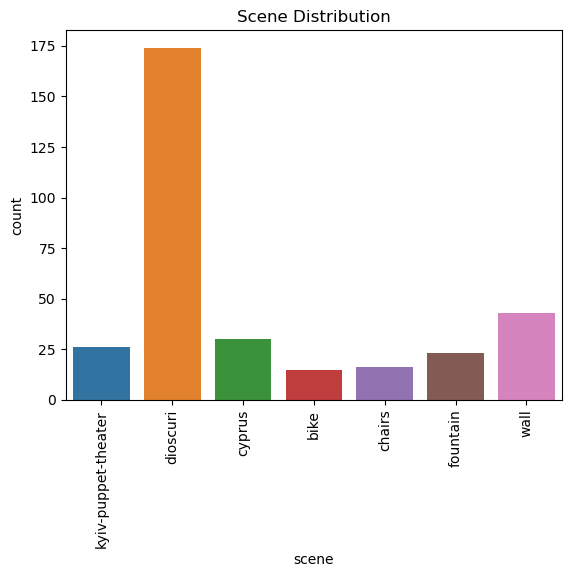

In [25]:
sns.countplot(data=train_labels,x='scene')
plt.title("Scene Distribution")
plt.xticks(rotation=90)
plt.show()

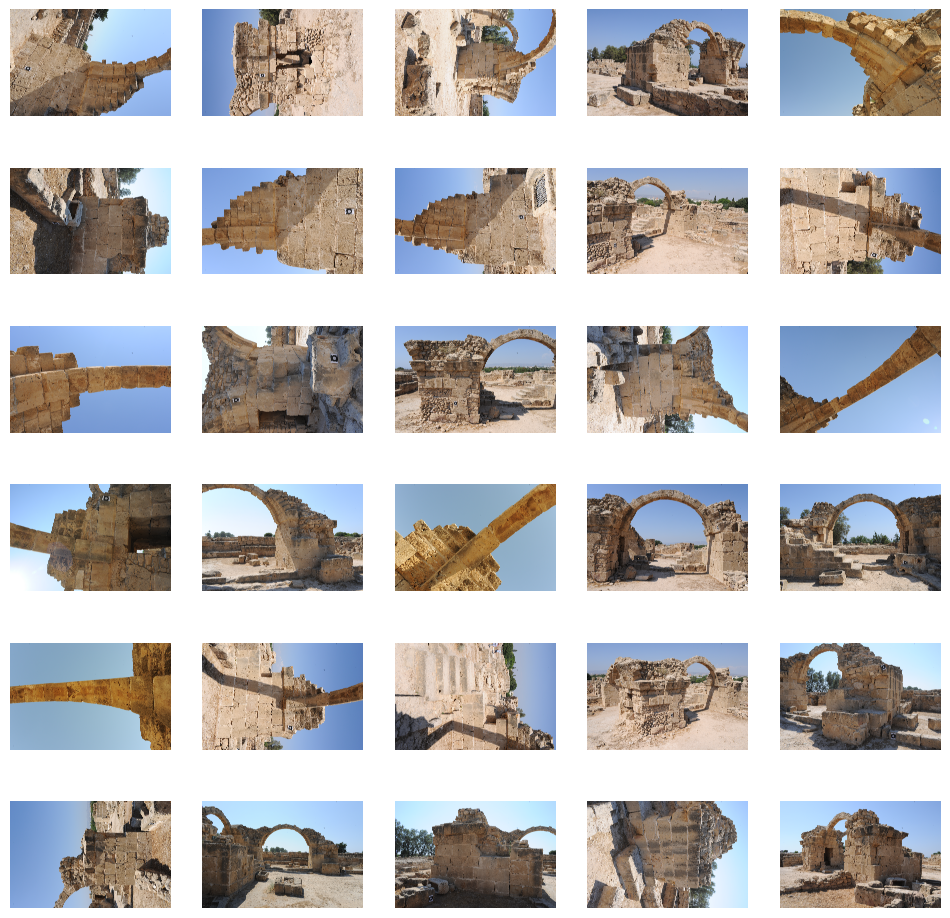

In [31]:
paths=[]
files=[]

for dirname,_,filenames in os.walk('/kaggle/input/image-matching-challenge-2023/train/heritage/cyprus/images'):
    for filename in filenames:
        paths +=[(os.path.join(dirname,filename))]
        files +=[filename]
        
fig,axs=plt.subplots(6,5,figsize=(12,12)) 
for i,ax in enumerate(axs.flat):
    if i <len(paths):
        img=mpimg.imread(paths[i])
        ax.imshow(img)
    ax.axis('off')
plt.show()    

In [30]:
len(files)

30

**Rotate Imgages**

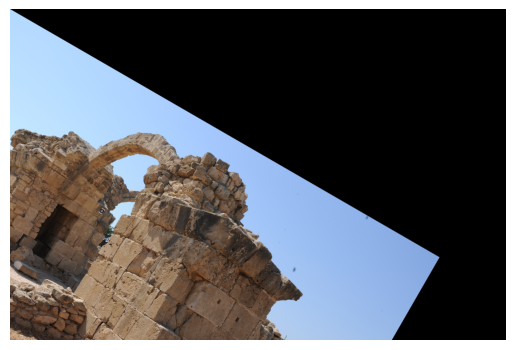

In [32]:
height,width = img.shape[:2]
theta_z = np.pi/6

R_z = np.array([[np.cos(theta_z), -np.sin(theta_z), 0],
                [np.sin(theta_z), np.cos(theta_z), 0],
                [0, 0, 1]])
rotated_img2 = cv2.warpAffine(img, R_z[:2,:], (width,height))
plt.imshow(rotated_img2)
plt.axis('off') 
plt.show()

**3D Reconstructions**

Detected model format: '.txt'


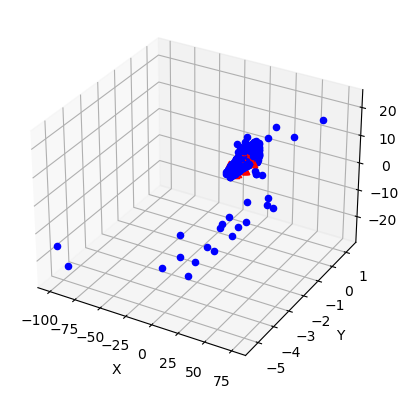

In [33]:
def plot_sfm_3d_reconstruction(reconstruction, num_points=1000, num_cameras=50):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    point3D_ids = list(reconstruction[2].keys())
    selected_point3D_ids = random.sample(point3D_ids, min(num_points, len(point3D_ids)))

    for point3D_id in selected_point3D_ids:
        point3D = reconstruction[2][point3D_id]
        ax.scatter(point3D.xyz[0], point3D.xyz[1], point3D.xyz[2], c='b', marker='o')

    image_ids = list(reconstruction[1].keys())
    selected_image_ids = random.sample(image_ids, min(num_cameras, len(image_ids)))

    for image_id in selected_image_ids:
        image = reconstruction[1][image_id]
        camera_center = -image.qvec2rotmat().T @ image.tvec
        ax.scatter(camera_center[0], camera_center[1], camera_center[2], c='r', marker='^')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()


sample_sfm_folder = os.path.join(train_path, 'heritage/cyprus/sfm')
cameras, images, points3D = read_write_model.read_model(sample_sfm_folder)
reconstruction = (cameras, images, points3D)
plot_sfm_3d_reconstruction(reconstruction)
        
    
        
    
    

In [34]:
def string_to_matrix(matrix_string):
    return np.array(list(map(float, matrix_string.split(';')))).reshape(3, 3)

def string_to_vector(vector_string):
    return np.array(list(map(float, vector_string.split(';'))))

In [35]:
rotation_matrices = train_labels['rotation_matrix'].apply(string_to_matrix)
translation_vectors = train_labels['translation_vector'].apply(string_to_vector)

# Calculate rotation angles (in degrees) for all images
rotation_angles = [np.rad2deg(np.arccos((np.trace(R) - 1) / 2)) for R in rotation_matrices]

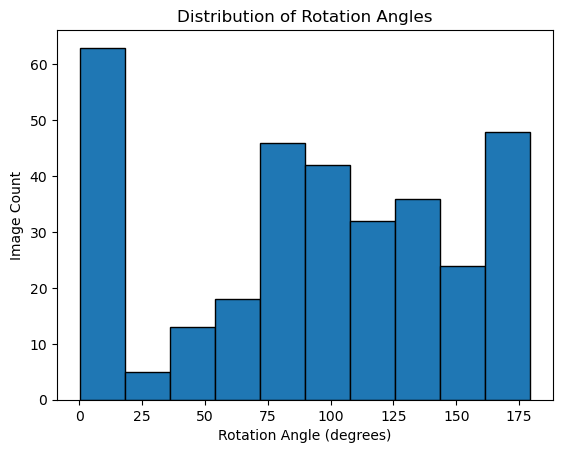

In [41]:
plt.figure()
plt.hist(rotation_angles,ec="black")
plt.xlabel('Rotation Angle (degrees)')
plt.ylabel('Image Count')
plt.title('Distribution of Rotation Angles')
plt.show()

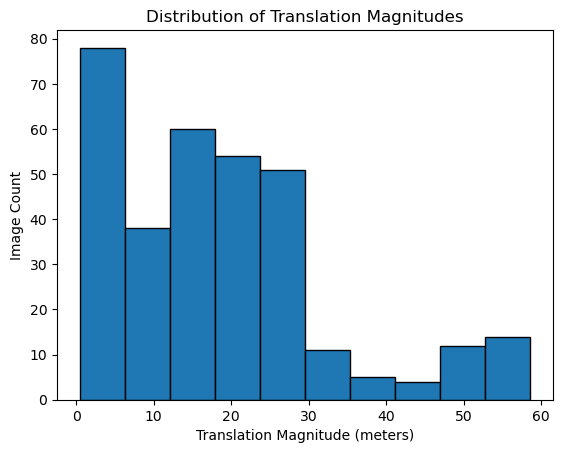

In [40]:
translation_magnitudes = [np.linalg.norm(tvec) for tvec in translation_vectors]

plt.figure()
plt.hist(translation_magnitudes,ec="black")
plt.xlabel('Translation Magnitude (meters)')
plt.ylabel('Image Count')
plt.title('Distribution of Translation Magnitudes')
plt.show()

**transform data**

In [42]:
train_transform = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    ToTensorV2()
   ])
validation_transform = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    ToTensorV2()
    ])

**Dataset Class**

In [43]:
class ImageDataset(Dataset):
    
    def __init__(self, root, img_path, rotation_label, translation_label, transforms=None):
    
        self.root=root 
        self.img_path=img_path 
        self.rotation_label = rotation_label 
        self.translation_label = translation_label
        self.transforms = transforms
        
    def __getitem__(self,index):
        
        img_path=self.img_path[index]
        img_path=self.root+img_path 
        image=cv2.imread(img_path)
        
        if self.transforms is not None:
            
            image=self.transforms(image=image)['image']
            
        rotation_label = self.rotation_label[index].split(";") 
        rotation_label=list(map(float, rotation_label))
        
        translation_label = self.translation_label[index].split(";")
        translation_label = list(map(float, translation_label))
        
        return image,np.array(rotation_label),np.array(translation_label)
    
    def __len__(self):
        return len(self.img_path)

In [50]:
def get_train_validation_set(df):
    validtion_data = df.sample(frac=0.3)
    training_data =  df[~df["image_path"].isin(validtion_data["image_path"])]
    return training_data,validtion_data


training_data,validation_data = get_train_validation_set(get_datasets(train_path,train_label))

**Roatation**

In [51]:
def get_translation_rotation(df):
    
    df["rotation_matrix_split"] = df.apply(lambda x:list(map(float, x["rotation_matrix"].split(";"))), axis=1)
    df["translation_vector_split"] = df.apply(lambda x:list(map(float, x["translation_vector"].split(";"))), axis=1)
    
    rotation_value=np.array(df["rotation_matrix_split"].tolist())
    
    translation_value = np.array(df["translation_vector_split"].tolist())
    
    
    return translation_value,rotation_value

translation_value,rotation_value=get_translation_rotation(get_datasets(train_path,train_label))
    

**Split Dataset**

In [52]:
def get_train_dataset(train_path,training_data):
    
    train_dataset=ImageDataset(train_path,training_data["image_path"].tolist(),training_data["rotation_matrix"].tolist(),training_data["translation_vector"].tolist(),transforms=train_transform)
    
    return train_dataset 

In [53]:
def get_validation_dataset(train_path,validation_data):    
    validation_dataset = ImageDataset(train_path, 
                        validation_data["image_path"].tolist(), 
                        validation_data["rotation_matrix"].tolist(), 
                        validation_data["translation_vector"].tolist(), 
                        transforms=validation_transform)
    return validation_dataset

**Dataloader**

In [54]:
def get_train_dataloader(train_dataset):
    
    train_loader=DataLoader(train_dataset,batch_size=4,shuffle=True,num_workers=2)
    
    return train_loader

def get_validation_dataloader(validation_dataset):
    
    validation_loader=DataLoader(validation_dataset,batch_size=4,shuffle=False)
    
    return validation_loader

In [55]:
train_loader=get_train_dataloader(get_train_dataset(train_path,training_data))
validation_loader = get_validation_dataloader(get_validation_dataset(train_path,validation_data))


**Image Matching Model**

In [56]:
class ImagemtachingModel(torch.nn.Module):
    
    def __init__(self,dropout=0.2):
        super(ImagemtachingModel, self).__init__()
        self.layer_one = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.layer_two=nn.Sequential(
        
            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=2)
        
        
        )
        
        self.layer_three=nn.Sequential(
        
            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=2)
        
        
        )
        
        self.layer_four=nn.Sequential(
        
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512), 
            nn.ReLU(), 
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=2)
        
        
        ) 
        
        self.layer_five=nn.Sequential(
        
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512), 
            nn.ReLU(), 
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=2), 
            nn.AvgPool2d(kernel_size=7)
        
        
        )
        
        self.layer_six=nn.Sequential(
            
           nn.Linear(512,512),
           nn.ReLU(), 
            
        
        )
        self.rotation_out = nn.Linear(512, 9)
        self.tanh = torch.nn.Tanh()
        
        self.translation_out = torch.nn.Linear(512, 3)
        
        
    def forward(self,x):
        
        x=self.layer_one(x)
        x = self.layer_two(x)
        x = self.layer_three(x)
        x = self.layer_four(x)
        x = self.layer_five(x)
        
        #Flatten 
        x=x.view(-1,512)
        
        x=self.layer_six(x)
        
        rotation_out=self.rotation_out(x)
        
        #tanh
        
        rotation_out = self.tanh(rotation_out)
        
        translation_out = self.translation_out(x)
        
        return rotation_out, translation_out
        

**Move Model To Cuda**

In [57]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [58]:
model = ImagemtachingModel(dropout=0.2)
model.to(device)

ImagemtachingModel(
  (layer_one): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer_two): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): MaxPool2d(kernel_size=2, st

**Optimization**

In [61]:
l1_distance=torch.nn.L1Loss()
optimizer=torch.optim.Adam(params=model.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)
best_loss = 1000000000
epochs = 10
best_model = None

**Training**

In [73]:
mtrain_loss=[]
mval_loss = []
mtrain_rot_loss = []
mtrain_trans_loss = []
mval_rot_loss = []
mval_trans_loss = []

for e in range(epochs):
    print(f'Epoch->{e+1}') 
    train_loss=[]
    rot_loss=[]
    trans_loss=[]
    
    val_loss = []
    val_rot_loss = []
    val_trans_loss = []
    
    #train loader
    
    for imgs, rotation_labels, translation_labels in tqdm(train_loader):
        
        model.train()
        optimizer.zero_grad()
        
        imgs=imgs.to(device)
        rotation_labels = rotation_labels.to(device)
        translation_labels = translation_labels.to(device)
        
        rotation_output ,translation_output=model(imgs)
        
        rotation_loss = l1_distance(rotation_output, rotation_labels)
        
        translation_loss = l1_distance(translation_output, translation_labels)
        
        loss=rotation_loss+translation_loss
        
        loss.backward()
        
        optimizer.step()
        
        train_loss.append(loss.item())
        
        rot_loss.append(rotation_loss.item())
        trans_loss.append(translation_loss.item())
        
    # validation loader  
        
    for imgs, rotation_labels, translation_labels in tqdm(validation_loader):
        model.eval()
        
        imgs = imgs.to(device)
        rotation_labels = rotation_labels.to(device)
        translation_labels = translation_labels.to(device)
        
        rotation_output, translation_output = model(imgs)
        rotation_loss = l1_distance(rotation_output, rotation_labels)
        translation_loss = l1_distance(translation_output, translation_labels)
        loss = rotation_loss + translation_loss
        
        val_loss.append(loss.item())
        val_rot_loss.append(rotation_loss.item())
        val_trans_loss.append(translation_loss.item())
        
    #mean loss 
    mtrain_loss.append(np.mean((train_loss)))
    mval_loss.append(np.mean((val_loss)))
    mtrain_rot_loss.append(np.mean((rot_loss)))
    mtrain_trans_loss.append(np.mean((trans_loss)))
    mval_rot_loss.append(np.mean((val_rot_loss)))
    mval_trans_loss.append(np.mean((val_trans_loss)))
    
    if scheduler is not None:
        scheduler.step(mval_loss[e])
    if best_loss < mval_loss[e]:
        best_loss = mval_loss[e]
        best_model = model    
          
    print(f'Train Loss : {mtrain_loss[e]:.5f} Train Rotation Loss : {mtrain_rot_loss[e]:.5f} Train Translation Loss : {mtrain_trans_loss[e]:.5f}')
    print(f'Val Loss : {mval_loss[e]:.5f} Val Rotation Loss : {mval_rot_loss[e]:.5f} Val Translation Loss : {mval_trans_loss[e]:.5f}')     

Epoch->1


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss : 6.03417 Train Rotation Loss : 0.41394 Train Translation Loss : 5.62023
Val Loss : 7.81639 Val Rotation Loss : 0.40574 Val Translation Loss : 7.41065
Epoch->2


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss : 6.10751 Train Rotation Loss : 0.40035 Train Translation Loss : 5.70716
Val Loss : 7.67264 Val Rotation Loss : 0.42528 Val Translation Loss : 7.24736
Epoch->3


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 00013: reducing learning rate of group 0 to 1.2500e-04.
Train Loss : 6.19907 Train Rotation Loss : 0.39789 Train Translation Loss : 5.80118
Val Loss : 7.20208 Val Rotation Loss : 0.41757 Val Translation Loss : 6.78451
Epoch->4


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss : 5.97481 Train Rotation Loss : 0.39797 Train Translation Loss : 5.57684
Val Loss : 7.25715 Val Rotation Loss : 0.40226 Val Translation Loss : 6.85489
Epoch->5


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss : 5.97943 Train Rotation Loss : 0.38868 Train Translation Loss : 5.59074
Val Loss : 7.17117 Val Rotation Loss : 0.39957 Val Translation Loss : 6.77160
Epoch->6


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 00016: reducing learning rate of group 0 to 6.2500e-05.
Train Loss : 6.13894 Train Rotation Loss : 0.39293 Train Translation Loss : 5.74601
Val Loss : 6.65617 Val Rotation Loss : 0.40441 Val Translation Loss : 6.25176
Epoch->7


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss : 6.01980 Train Rotation Loss : 0.38217 Train Translation Loss : 5.63764
Val Loss : 7.57257 Val Rotation Loss : 0.40381 Val Translation Loss : 7.16876
Epoch->8


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss : 5.85002 Train Rotation Loss : 0.37989 Train Translation Loss : 5.47013
Val Loss : 6.82903 Val Rotation Loss : 0.39919 Val Translation Loss : 6.42983
Epoch->9


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 00019: reducing learning rate of group 0 to 3.1250e-05.
Train Loss : 5.96878 Train Rotation Loss : 0.38341 Train Translation Loss : 5.58538
Val Loss : 7.09981 Val Rotation Loss : 0.40076 Val Translation Loss : 6.69905
Epoch->10


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss : 5.73077 Train Rotation Loss : 0.38322 Train Translation Loss : 5.34756
Val Loss : 7.25753 Val Rotation Loss : 0.40162 Val Translation Loss : 6.85592


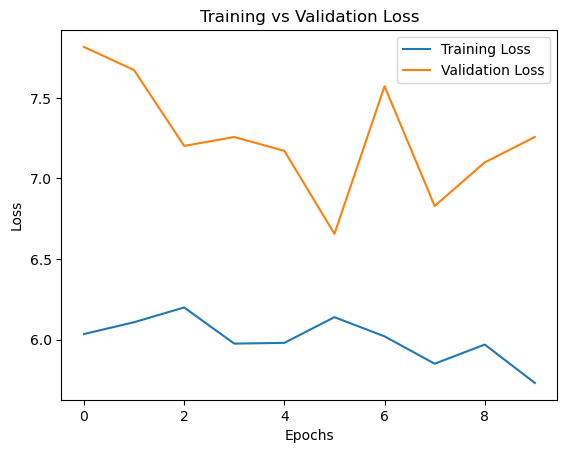

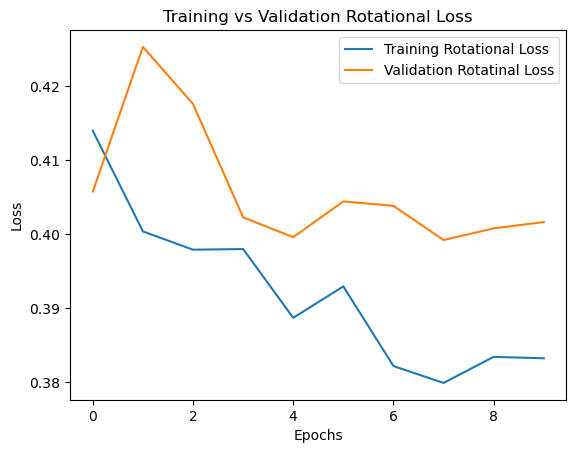

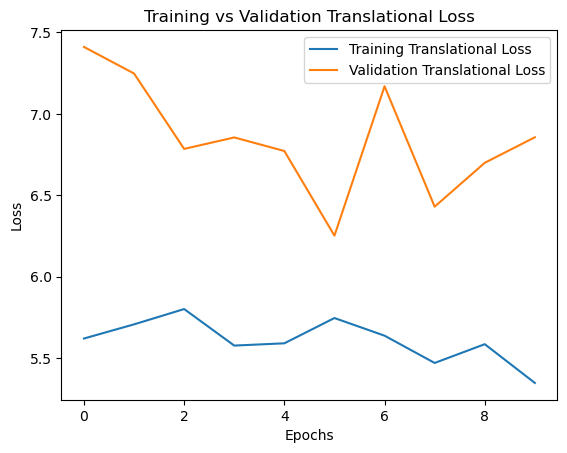

In [75]:
# mtrain_loss=np.mean(train_loss)
#     mval_loss = np.mean(val_loss)
#     mtrain_rot_loss = np.mean(rot_loss)
#     mtrain_trans_loss = np.mean(trans_loss)
#     mval_rot_loss = np.mean(val_rot_loss)
#     mval_trans_loss = np.mean(val_trans_loss)
plt.plot(range(epochs), mtrain_loss, label='Training Loss')
plt.plot(range(epochs), mval_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(range(epochs), mtrain_rot_loss, label='Training Rotational Loss')
plt.plot(range(epochs), mval_rot_loss, label='Validation Rotatinal Loss')
plt.title('Training vs Validation Rotational Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(range(epochs), mtrain_trans_loss, label='Training Translational Loss')
plt.plot(range(epochs), mval_trans_loss, label='Validation Translational Loss')
plt.title('Training vs Validation Translational Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Prediction & Submission**

In [76]:
def arr_to_str(a):
    return ';'.join([str(x) for x in a.reshape(-1)])

In [79]:
submission = pd.read_csv("/kaggle/input/image-matching-challenge-2023/sample_submission.csv")
submission.head(2).T

,0,1
image_path,2cfa01ab573141e4/2fa124afd1f74f38/images/09387...,2cfa01ab573141e4/2fa124afd1f74f38/images/11c07...
dataset,2cfa01ab573141e4,2cfa01ab573141e4
scene,2fa124afd1f74f38,2fa124afd1f74f38
rotation_matrix,0.3700584878256019;0.7870891328233803;0.632781...,0.24107462449034978;0.6324667958150785;0.66208...
translation_vector,0.12296637725515835;0.6206590405309732;0.10571...,0.30084987667667396;0.6212308657300727;0.66494...


In [80]:
test_rotation_list=[]
test_translation_list=[]
test_img_list=[]
test_dataset_list = []
test_scene_list = []

for i in range(len(submission)):
    
    test_row=submission.iloc[i]
    test_img=test_row["image_path"]
    test_dataset = test_row["dataset"]
    test_scene = test_row["scene"]
    img_path = f"{root}/test/{test_img}"
    
    try:
        image=cv2.imread(img_path)
        image=test_transforms(image=image)['image']
        rotation = arr_to_str(rotation.detach().cpu().numpy())
        translation = arr_to_str(translation.detach().cpu().numpy())
        
    except:
        rotation = "1.0;0.0;0.0;0.0;1.0;0.0;0.0;0.0;1.0"
        translation = "0.0;0.0;0.0"
    
    test_rotation_list.append(rotation)
    test_translation_list.append(translation)
    test_img_list.append(test_img)
    test_dataset_list.append(test_dataset)
    test_scene_list.append(test_scene) 

In [81]:
my_submission=pd.DataFrame()
my_submission["image_path"]=test_img_list
my_submission["dataset"] = test_dataset_list
my_submission["scene"] = test_scene_list
my_submission["rotation_matrix"] = test_rotation_list
my_submission["translation_vector"] = test_translation_list

my_submission.to_csv("submission.csv",index=False)

In [83]:
test_df=pd.read_csv("/kaggle/working/submission.csv")
test_df.head().T

,0,1,2
image_path,2cfa01ab573141e4/2fa124afd1f74f38/images/09387...,2cfa01ab573141e4/2fa124afd1f74f38/images/11c07...,2cfa01ab573141e4/2fa124afd1f74f38/images/11d54...
dataset,2cfa01ab573141e4,2cfa01ab573141e4,2cfa01ab573141e4
scene,2fa124afd1f74f38,2fa124afd1f74f38,2fa124afd1f74f38
rotation_matrix,1.0;0.0;0.0;0.0;1.0;0.0;0.0;0.0;1.0,1.0;0.0;0.0;0.0;1.0;0.0;0.0;0.0;1.0,1.0;0.0;0.0;0.0;1.0;0.0;0.0;0.0;1.0
translation_vector,0.0;0.0;0.0,0.0;0.0;0.0,0.0;0.0;0.0
